In [65]:
%load_ext autoreload
%autoreload 2
import os
#change current working directory to the parent directory
import sys

import numpy as np
from SRtools import sr_mcmc as srmc
import argparse
from SRtools import config_lib as cl
from SRtools import deathTimesDataSet as dtds
import ast
from SRtools import readResults as rr
import corner
import matplotlib.pyplot as plt
import matplotlib
from SRtools import SRmodellib as sr
from SRtools import SRmodellib_lifelines as srl
import emcee
from SRtools import samples_utils as su
from SRtools import joint_posterior as jp
from SRtools import SR_hetro as srhs
from SRtools import presets
import SR_noises as srn


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
configs = ['celegans', 'mice_F', 'Sweden_M_1910_hetro']
thetas= {}
params = {}
for config in configs:
    thetas[config] = presets.getTheta(config)
    params[config] = presets.get_config_params(config)
    params[config]['time_step_multiplier'] = np.ceil(params[config]['time_step_multiplier'])



Using alias 'celegans' -> 'celegans'
Using alias 'celegans' -> 'celegans'
Converting time units: days -> weeks (s=7.0)
Converting time units: days -> years (s=365.0)


In [69]:
sims_normal = {}
sims_poisson = {}
sims_multiplicative = {}

mult_facts ={
    'Sweden_M_1910_hetro': 1.24,
    'mice_F': 1.3,
    'celegans': 1.6
}

npeople = 20000

for config in configs:
    theta_poisson = thetas[config].copy()
    theta_multiplicative = thetas[config].copy()
    theta_poisson[2] *= 0.7

    theta_multiplicative[2] *= mult_facts[config]
    if config in ['celegans']:
        theta_poisson[2] *= 1.2
        theta_poisson[1] *= 1.2
        theta_multiplicative[0] *= 1.02
    if config in ['mice_F']:
        theta_poisson[2] *= 1
        theta_poisson[0] *= 0.95
    if config in ['Sweden_M_1910_hetro']:
        theta_multiplicative[3]*=0.95
        theta_poisson[2] *= 1
    theta_poisson[1] += 2*theta_poisson[2]
    sims_normal[config] = srn.getSr_noises(thetas[config], n=npeople, nsteps=params[config]['nsteps'], t_end=params[config]['t_end'], time_step_multiplier=params[config]['time_step_multiplier'], parallel=True, hetro=params[config]['hetro'], noise_type='normal')
    sims_poisson[config] = srn.getSr_noises(theta_poisson, n=npeople, nsteps=params[config]['nsteps'], t_end=params[config]['t_end'], time_step_multiplier=params[config]['time_step_multiplier'], parallel=True, hetro=params[config]['hetro'], noise_type='poisson')
    sims_multiplicative[config] = srn.getSr_noises(theta_multiplicative, n=npeople, nsteps=params[config]['nsteps'], t_end=params[config]['t_end'], time_step_multiplier=params[config]['time_step_multiplier'], parallel=True, hetro=params[config]['hetro'], noise_type='multiplicative_normal_beta')






In [78]:
0.7*1.2

0.84

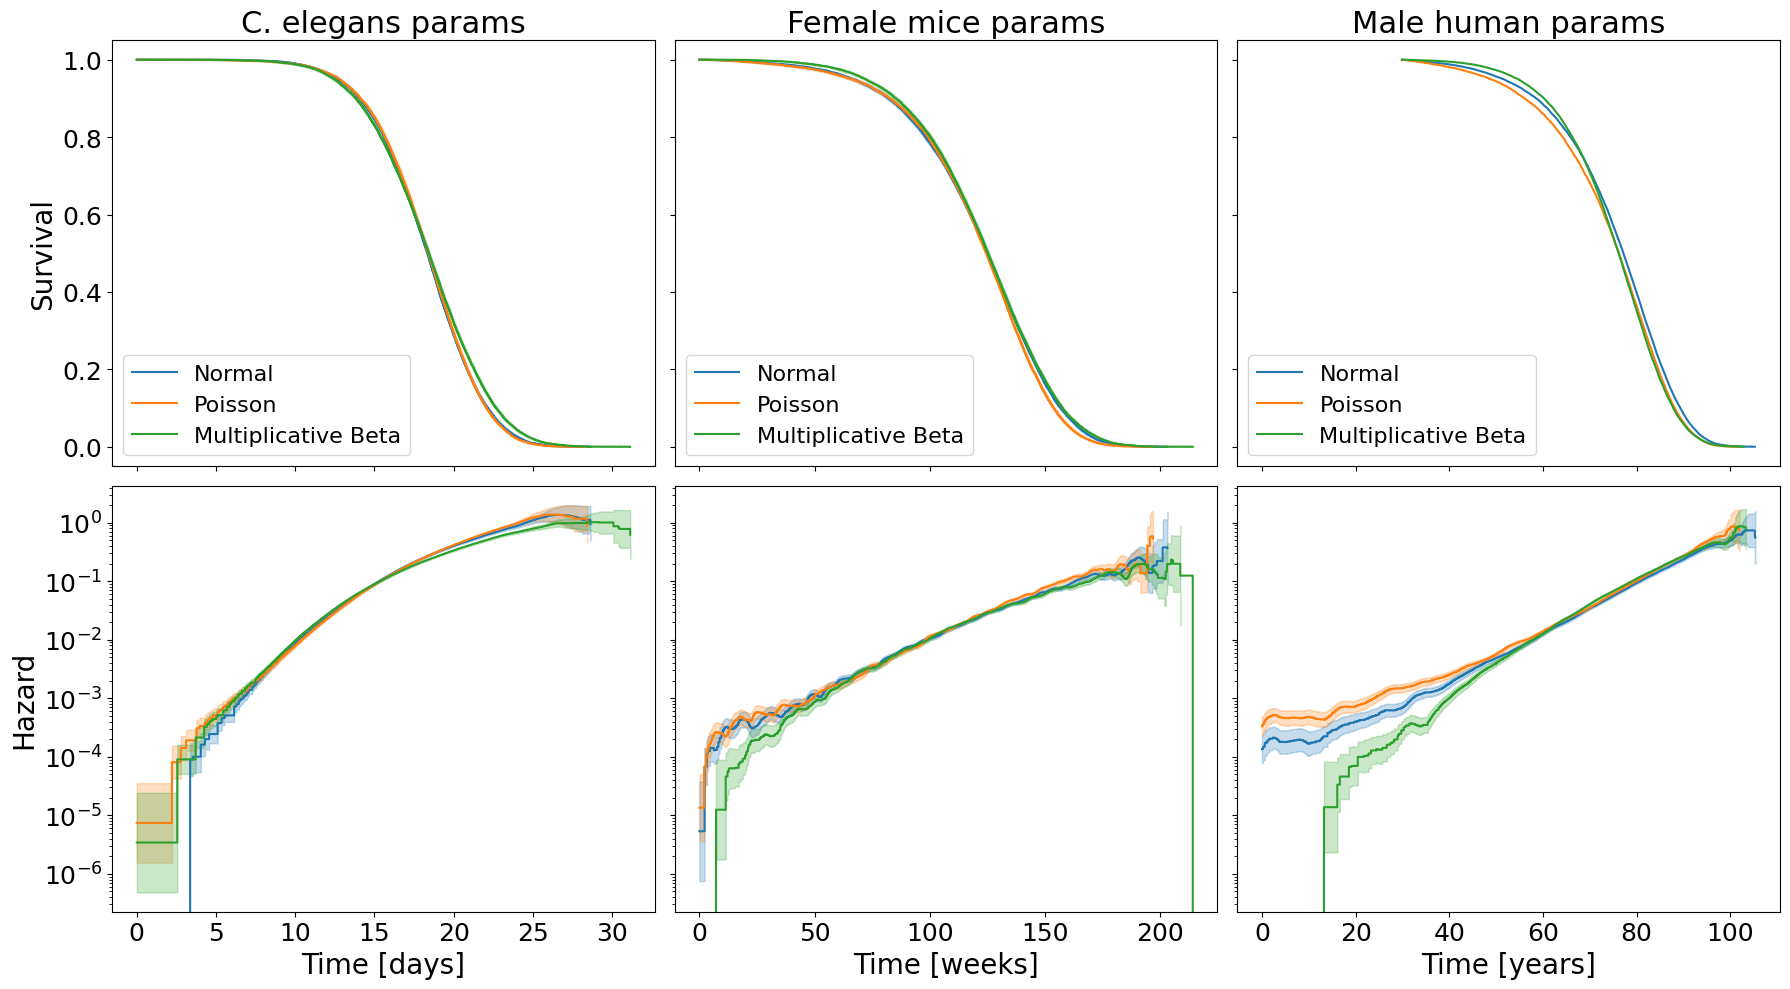

In [77]:
fig, axes = plt.subplots(2, len(configs), figsize=(6*len(configs), 10), sharex='col', sharey='row')

# Titles and x-axis labels for each group
column_titles = [
    "C. elegans params",
    "Female mice params",
    "Male human params"
]
x_labels = [
    "Time [days]",
    "Time [weeks]",
    "Time [years]"
]

noise_labels = {
    'normal': 'Normal',
    'poisson': 'Poisson',
    'multiplicative_normal_beta': 'Multiplicative Beta'
}

title_fontsize = 22
label_fontsize = 20
tick_fontsize = 18
legend_fontsize = 16

for i, key in enumerate(thetas.keys()):
    # Survival curves (top row)
    sims_normal[key].plotSurvival(color=None, ax=axes[0, i], time_range=params[key]['time_range'], label=noise_labels['normal'])
    sims_poisson[key].plotSurvival(color=None, ax=axes[0, i], time_range=params[key]['time_range'], label=noise_labels['poisson'])
    sims_multiplicative[key].plotSurvival(color=None, ax=axes[0, i], time_range=params[key]['time_range'], label=noise_labels['multiplicative_normal_beta'])
    # Titles and axes: use index for lookup, fallback gracefully
    if i < len(column_titles):
        axes[0, i].set_title(column_titles[i], fontsize=title_fontsize)
        axes[0, i].set_xlabel(x_labels[i], fontsize=label_fontsize)
    else:
        axes[0, i].set_title(f"{key.capitalize()} — different noises", fontsize=title_fontsize)
        axes[0, i].set_xlabel("Time", fontsize=label_fontsize)
    if i == 0:
        axes[0, i].set_ylabel("Survival", fontsize=label_fontsize)
    axes[0, i].legend(fontsize=legend_fontsize)
    axes[0, i].tick_params(axis='both', which='major', labelsize=tick_fontsize)

    # Hazard curves (bottom row)
    sims_normal[key].plotHazard(color=None, ax=axes[1, i], label=noise_labels['normal'])
    sims_poisson[key].plotHazard(color=None, ax=axes[1, i], label=noise_labels['poisson'])
    sims_multiplicative[key].plotHazard(color=None, ax=axes[1, i], label=noise_labels['multiplicative_normal_beta'])
    if i < len(x_labels):
        axes[1, i].set_xlabel(x_labels[i], fontsize=label_fontsize)
    else:
        axes[1, i].set_xlabel("Time", fontsize=label_fontsize)
    if i == 0:
        axes[1, i].set_ylabel("Hazard", fontsize=label_fontsize)
    axes[1, i].get_legend().remove() if axes[1, i].get_legend() is not None else None
    axes[1, i].set_yscale('log')
    axes[1, i].tick_params(axis='both', which='major', labelsize=tick_fontsize)

plt.tight_layout()
fig.savefig("plot - supplemantery different noises.pdf")
fig.savefig("plot - supplemantery different noises.jpg", format='jpg', dpi=300)

plt.show()
